In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.tools.plotting import parallel_coordinates

import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

from scipy import stats
import math

In [2]:
xls = pd.ExcelFile('2014年基本信息表.xls')
data_upperHalf = xls.parse('基本信息表2014上半年')
data_lowerHalf = xls.parse('基本信息表2014下半年')
data = pd.DataFrame()
data = pd.concat([data_upperHalf,data_lowerHalf],ignore_index=True)

xls = pd.ExcelFile('2015年基本信息表.xls')
data_upperHalf = xls.parse('基本信息表2015年上半年')
data_lowerHalf = xls.parse('基本信息表2015年上半年')
data = pd.concat([data,data_upperHalf,data_lowerHalf],ignore_index=True)

xls = pd.ExcelFile('2016年基本信息表.xls')
data_upperHalf = xls.parse('2016年上半年基本信息表')
data_lowerHalf = xls.parse('2016年下半年基本信息表')
data = pd.concat([data,data_upperHalf,data_lowerHalf],ignore_index=True)
xls.close()

del data_upperHalf
del data_lowerHalf

#### 加入天气特征 

In [3]:
data_accident = data[['事故编号','天气','能见度','公安部事故编号','所属中队','文书状态','所辖乡镇','现场','行政区划','调解人1','调解人2',\
                         '受伤人数','失踪人数','当事人总数','抢救死亡人数Q','损坏机动车数','损坏非机动车数','机动车数量','死亡人数',\
                      '直接财产损失','米数','轻伤人数','重伤人数','非机动车数量','行人数量',\
                          '事故发生时间','星期','事故地点','路号','路名',\
                          '事故形态','事故类型','单车事故','是否简易程序','路外事故类型','车辆间事故.1','逃逸事故侦破',\
                          '事故初查原因','事故初查原因分类','事故认定原因','事故认定原因分类小类']]
del data

In [ ]:
# data_accident = data_accident.drop(['公安部事故编号','所属中队','文书状态','调解人1','调解人2',],axis=1)

data_accident = data_accident[data_accident.事故形态.isin(['碰撞运动车辆','其他车辆事故',\
                                                '刮撞行人','撞固定物',\
                                                '撞非固定物','碾压行人',\
                                                '侧翻','碰撞静止车辆',\
                                                '碰撞后碾压行人','其他车辆与人事故',\
                                                '坠车','乘员跌落或抛出',\
                                                '翻滚','失火','自身摺叠'])]

data_accident['路外事故类型'].fillna('否',inplace=True)
data_accident.rename(columns={'路外事故类型':'是否路外事故'},inplace=True)
data_accident['逃逸事故侦破'].fillna('非逃逸',inplace=True)
data_accident['单车事故'].fillna('非单车事故',inplace=True)
data_accident.dropna(subset=['车辆间事故.1'],how='any',axis=0,inplace=True)

data_accident.drop(['事故初查原因','事故初查原因分类'],axis=1,inplace=True)
data_accident.dropna(subset=['事故认定原因','事故认定原因分类小类'],axis=0,inplace=True)

data_accident['当事人总数'].fillna(-1,inplace=True)
data_accident['机动车数量'].fillna(-1,inplace=True)
data_accident['非机动车数量'].fillna(-1,inplace=True)
data_accident['行人数量'].fillna(-1,inplace=True)

data_accident['米数'].fillna(-1,inplace=True)
data_accident.drop(['失踪人数','损坏机动车数','损坏非机动车数'],axis=1,inplace=True)

data_accident.drop(['现场'],axis=1,inplace=True)

data_accident = data_accident.dropna(subset=['路名','所辖乡镇'],axis=0,how='any')



for i in data_accident.columns:
    print('%s缺失率：%s'%(i,sum(data_accident[i].isnull())/len(data_accident)))
    
    


#### 重新编号

In [5]:
data_accident['index'] = range(len(data_accident))
data_accident = data_accident.set_index(['index'])

#### 暂时删除能见度 

In [6]:
data_accident.drop(['能见度'],axis=1,inplace=True)

In [7]:
for i in data_accident.columns:
    print('%s缺失率：%s'%(i,sum(data_accident[i].isnull())/len(data_accident)))

事故编号缺失率：0.0
天气缺失率：0.0
所辖乡镇缺失率：0.0
行政区划缺失率：0.0
受伤人数缺失率：0.0
当事人总数缺失率：0.0
抢救死亡人数Q缺失率：0.0
机动车数量缺失率：0.0
死亡人数缺失率：0.0
直接财产损失缺失率：0.0
米数缺失率：0.0
轻伤人数缺失率：0.0
重伤人数缺失率：0.0
非机动车数量缺失率：0.0
行人数量缺失率：0.0
事故发生时间缺失率：0.0
星期缺失率：0.0
事故地点缺失率：0.0
路号缺失率：0.0
路名缺失率：0.0
事故形态缺失率：0.0
事故类型缺失率：0.0
单车事故缺失率：0.0
是否简易程序缺失率：0.0
是否路外事故缺失率：0.0
车辆间事故.1缺失率：0.0
逃逸事故侦破缺失率：0.0
事故认定原因缺失率：0.0
事故认定原因分类小类缺失率：0.0


## 1.1 事故发生时间 

### 1.1.1 存储事故发生时间用于获取是否节假日 

In [115]:
date = pd.to_datetime(data_accident['事故发生时间'])
date_toSave = pd.DataFrame(date)
date_toSave['index'] = range(len(date_toSave))
date_toSave = date_toSave.set_index(['index'])
d = pd.DataFrame()
d.insert(loc=0,value=date_toSave,column='date')
d.to_csv('accidentTime_17.10.23.csv')

#### 获取2014-2016年所有日期是否节假日信息

#是否节假日
import json
import urllib
import datetime

isHoliday = list()
date = pd.to_datetime(data_accident['事故发生时间'])
server_url = "http://tool.bitefu.net/jiari/?d="



req = urllib.request
for i in date:
    month = str(i.month)
    day = str(i.day)
    if i.month<10:
        month =  '0'+str(i.month) 
    if i.day<10:
        day = '0'+str(i.day)
    day = str(i.year)+month+day
    vop_response = req.urlopen(server_url+day)
    date_isHoliday= json.loads(vop_response.read())
    isHoliday.append(date_isHoliday)
    


isHoliday = pd.DataFrame(isHoliday)
data_accident.insert(column='是否节假日',value=isHoliday,loc=1)

In [211]:
#是否节假日
import json
import urllib
import datetime

date = pd.read_csv('accidentTime_17.10.23.csv')
date.drop(['Unnamed: 0'],axis=1,inplace=True)
date = pd.to_datetime(date['date'])
isHoliday = list()
server_url = "http://tool.bitefu.net/jiari/?d="

date_start = '2014-01-01'
date_end = '2016-12-31'
date_start = datetime.datetime.strptime(date_start,'%Y-%m-%d')
date_end = datetime.datetime.strptime(date_end,'%Y-%m-%d')

#获取整个日期范围
date_all = list()
while date_start<=date_end:
    date_all.append(date_start)
    date_start += datetime.timedelta(1)
print(len(date_all))

date_isHoliday = pd.DataFrame()

date_isHoliday.insert(loc=0,column='date',value=pd.DataFrame(date_all))



for i in date_all:
    day = str(i.day)
    month = str(i.month)
    if i.day<10:
        day = '0'+day
    if i.month<10:
        month = '0'+month
    theDate = str(i.year)+month+day
    req = urllib.request
    res = req.urlopen(server_url+theDate)
    isHoliday.append(json.loads(res.read()))
    
isHoliday_df = pd.DataFrame(isHoliday)

date_isHoliday.insert(loc=1,column='isHoliday',value=isHoliday_df)
print('isHoliday缺失率：%s'%(sum(date_isHoliday['isHoliday'].isnull())/len(date_isHoliday)))

def get_dateDay(date):
    theDay = str(date.day)
    theMonth = str(date.month)
    if date.day<10:
        theDay = '0'+theDay
    if date.month<10:
        theMonth = '0'+theMonth
    return str(date.year)+theMonth+theDay

date_day = pd.DataFrame(pd.to_datetime(date_isHoliday['date']).apply(get_dateDay))
date_isHoliday.insert(0,'date_day',date_day)

date_isHoliday.to_excel('isHolidayFrom140101To161231_17.10.23_re.xlsx')

del date,isHoliday,date_start,date_end,date_all,isHoliday_df,date_day,date_isHoliday

1096
isHoliday缺失率：0.0


In [220]:
isHolidayFrom140101To161231 = pd.read_excel('isHolidayFrom140101To161231_17.10.23_re.xlsx')
date = pd.read_csv('accidentTime_17.10.23.csv')
date.drop(['Unnamed: 0'],axis=1,inplace=True)
date = pd.to_datetime(date['date'])

def getAccidentDayWithoutHour(i):
    day = str(i.day)
    month = str(i.month)
    if i.day<10:
        day = '0'+day
    if i.month<10:
        month = '0'+month
    theDate = str(i.year)+month+day
    return theDate

accidentDayWithoutHour = pd.DataFrame(date.apply(getAccidentDayWithoutHour))



isHolidays = list()
for i in accidentDayWithoutHour['date']:
    isH = isHolidayFrom140101To161231[isHolidayFrom140101To161231.date_day==int(i)]['isHoliday'].iloc[0]
    isHolidays.append(isH)
print(len(isHolidays))

isHolidays = pd.DataFrame(isHolidays)
isHolidays['index'] = range(len(isHolidays))
isHolidays = isHolidays.set_index(['index'])
data_accident.insert(loc=1,column='是否节假日',value=isHolidays)

del isHolidayFrom140101To161231,accidentDayWithoutHour,isHolidays,isH

### 1.1.2 处理 白天或夜晚 

In [90]:
#白天或夜晚
isDayorNight = list()
for i in date:
    if i.hour>=19 or i.hour<7:
        isDayorNight.append('夜晚')
    else:
        isDayorNight.append('白天')
isDayorNight = pd.Series(isDayorNight)

data_accident.insert(2,'是否白天',isDayorNight)

print('data_accident[是否白天]缺失率:%s'%(sum(data_accident['是否白天'].isnull())/len(data_accident)))
print('data_accident长度：%s'%len(data_accident))

del isDayorNight

data_accident[是否白天]缺失率:0.0
data_accident长度：133345


In [221]:
for i in data_accident.columns:
    print('%s缺失率：%s'%(i,sum(data_accident[i].isnull())/len(data_accident)))

事故编号缺失率：0.0
事故发生时间缺失率：0.0
是否节假日缺失率：0.0
是否白天缺失率：0.0
天气缺失率：0.0
所辖乡镇缺失率：0.0
行政区划缺失率：0.0
受伤人数缺失率：0.0
当事人总数缺失率：0.0
抢救死亡人数Q缺失率：0.0
机动车数量缺失率：0.0
死亡人数缺失率：0.0
直接财产损失缺失率：0.0
米数缺失率：0.0
轻伤人数缺失率：0.0
重伤人数缺失率：0.0
非机动车数量缺失率：0.0
行人数量缺失率：0.0
星期缺失率：0.0
事故地点缺失率：0.0
路号缺失率：0.0
路名缺失率：0.0
事故形态缺失率：0.0
事故类型缺失率：0.0
单车事故缺失率：0.0
是否简易程序缺失率：0.0
是否路外事故缺失率：0.0
车辆间事故.1缺失率：0.0
逃逸事故侦破缺失率：0.0
事故认定原因缺失率：0.0
事故认定原因分类小类缺失率：0.0


In [206]:
data_accident.head()
data_accident.to_excel('data_accident_17.10.23.xlsx')

## 1.2 所辖乡镇 

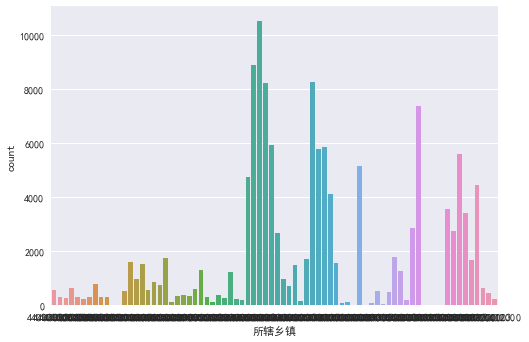

In [10]:
sns.countplot(data_accident['所辖乡镇'])